## Imports

In [4]:
import numpy as np
import pandas as pd
import os
import urllib.request

## Data preprocessing

In [188]:
esol_url = 'https://raw.githubusercontent.com/gsi-lab/GC-GNN/main/datasets/ESOL.csv'

root = os.getcwd()
esol_path = os.path.join(root,'esol.csv')

if not os.path.exists(esol_path):
    urllib.request.urlretrieve(esol_url, esol_path)
print("Downloaded ESOL")

Downloaded ESOL


In [189]:
esol_df = pd.read_csv(esol_path)
esol_df.head(10)

,Name,Const_Value,ESOL_Value,SMILES,Family
0,Amigdalin,-0.77,-0.974,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,NaN
1,Fenfuram,-3.30,-2.885,Cc1occc1C(=O)Nc2ccccc2,NaN
2,citral,-2.06,-2.579,CC(C)=CCCC(C)=CC(=O),NaN
3,Picene,-7.87,-6.618,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,NaN
4,Thiophene,-1.33,-2.232,c1ccsc1,NaN
5,benzothiazole,-1.50,-2.733,c2ccc1scnc1c2,NaN
6,"2,2,4,6,6'-PCB",-7.32,-6.545,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl,NaN
7,Estradiol,-5.03,-4.138,CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O,NaN
8,Dieldrin,-6.29,-4.533,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl,NaN
9,Rotenone,-4.42,-5.246,COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C,NaN


In [6]:
data = esol_df.loc[:,['SMILES','ESOL_Value']]
data

,SMILES,ESOL_Value
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.974
1,Cc1occc1C(=O)Nc2ccccc2,-2.885
2,CC(C)=CCCC(C)=CC(=O),-2.579
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-6.618
4,c1ccsc1,-2.232
...,...,...
1123,FC(F)(F)C(Cl)Br,-2.608
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,-0.908
1125,CCSCCSP(=S)(OC)OC,-3.323
1126,CCC(C)C,-2.245


## Model building

### Attentive FP 

In [7]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import edge_softmax

class Atom_AFPLayer(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.hidden_dim = net_params['hidden_dim']
        self.embedding_node_lin = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=True),
            nn.LeakyReLU()
        )
        self.embedding_edge_lin = nn.Sequential(
            nn.Linear(self.hidden_dim + self.hidden_dim, self.hidden_dim, bias=True),
            nn.LeakyReLU()
        )
        self.cal_alignment = nn.Sequential(
            nn.Dropout(net_params['dropout']),
            nn.Linear(self.hidden_dim + self.hidden_dim, 1, bias=True),
            nn.LeakyReLU()
        )
        self.attend = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        )
        self.GRUCell = nn.GRUCell(self.hidden_dim, self.hidden_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.embedding_node_lin[0].reset_parameters()
        self.embedding_edge_lin[0].reset_parameters()
        self.cal_alignment[1].reset_parameters()
        self.attend[0].reset_parameters()
        self.GRUCell.reset_parameters()

    def update_edge_by_neighbor(self, edges):
        neighbor_message = self.embedding_edge_lin(torch.cat([edges.src['node_embedded_feats'], edges.data['edge_feats']], dim=-1))
        return {'neighbor_message': neighbor_message}

    def cal_alignment_score(self, edges):
        alignment_score = self.cal_alignment(torch.cat([edges.data['neighbor_message'], edges.dst['node_embedded_feats']], dim=-1))
        return {'score': alignment_score}

    def att_context_passing(self, edges):
        return {'mail': edges.data['att_context']}

    def cal_context(self, nodes):
        return {'context': torch.sum(nodes.mailbox['mail'], dim=-2)}

    def forward(self, graph, node, edge):
        graph = graph.local_var()
        graph.ndata['node_feats'] = node
        graph.ndata['node_embedded_feats'] = self.embedding_node_lin(graph.ndata['node_feats'])
        graph.edata['edge_feats'] = edge

        # update the edge feats by concat edge feats together with the neighborhood node feats
        graph.apply_edges(self.update_edge_by_neighbor)
        graph.apply_edges(self.cal_alignment_score)
        graph.edata['att_context'] = edge_softmax(graph, graph.edata['score']) * self.attend(graph.edata['neighbor_message'])
        graph.update_all(self.att_context_passing, self.cal_context)
        context = F.elu(graph.ndata['context'])
        new_node = F.relu(self.GRUCell(context, graph.ndata['node_embedded_feats']))
        return new_node


class Atom_AttentiveFP(nn.Module):
    # Generate Context of each nodes
    def __init__(self, net_params):
        super().__init__()
        self.PassingDepth = nn.ModuleList([Atom_AFPLayer(net_params) for _ in range(net_params['depth'])])
        self.reset_parameters()

    def reset_parameters(self):
        for l in self.PassingDepth:
            l.reset_parameters()

    def forward(self, graph, node, edge):
        with graph.local_scope():
            for step in self.PassingDepth:
                node = step(graph, node, edge)
        return node


class Mol_AFPLayer(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.GRUCell = nn.GRUCell(net_params['hidden_dim'], net_params['hidden_dim'])

        self.cal_alignment = nn.Sequential(
            nn.Linear(net_params['hidden_dim'] + net_params['hidden_dim'], 1, bias=True),
            nn.LeakyReLU()
        )
        self.attend = nn.Sequential(
            nn.Dropout(net_params['dropout']),
            nn.Linear(net_params['hidden_dim'], net_params['hidden_dim'], bias=True)
        )
        self.reset_parameters()

    def reset_parameters(self):
        self.GRUCell.reset_parameters()
        self.cal_alignment[0].reset_parameters()
        self.attend[1].reset_parameters()

    def forward(self, graph, super_node, node):
        graph = graph.local_var()
        super_node = F.leaky_relu(super_node)

        graph.ndata['score'] = self.cal_alignment(torch.cat([node, dgl.broadcast_nodes(graph, super_node)], dim=1))
        graph.ndata['attention_weight'] = dgl.softmax_nodes(graph, 'score')
        graph.ndata['hidden_node'] = self.attend(node)
        super_context = F.elu(dgl.sum_nodes(graph, 'hidden_node', 'attention_weight'))
        super_node = F.relu(self.GRUCell(super_context, super_node))
        return super_node, graph.ndata['attention_weight']


class Mol_AttentiveFP(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.MultiTimeSteps = nn.ModuleList([Mol_AFPLayer(net_params) for d in range(net_params['layers'])])
        self.reset_parameters()

    def reset_parameters(self):
        for l in self.MultiTimeSteps:
            l.reset_parameters()

    def forward(self, graph, node):
        with graph.local_scope():
            attention_list = []
            graph.ndata['hidden_node'] = node
            super_node = dgl.sum_nodes(graph, 'hidden_node')
            for step in self.MultiTimeSteps:
                super_node, attention_t = step(graph, super_node, node)
                attention_list.append(attention_t)
            attention_list = torch.cat(attention_list, dim=1)
        return super_node, attention_list


class AttentiveFPNet(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.embedding_node_lin = nn.Sequential(
            nn.Linear(net_params['num_atom_type'], net_params['hidden_dim'], bias=True),
            nn.LeakyReLU()
        )
        self.embedding_edge_lin = nn.Sequential(
            nn.Linear(net_params['num_bond_type'], net_params['hidden_dim'], bias=True),
            nn.LeakyReLU()
        )
        self.Atom_Attentive = Atom_AttentiveFP(net_params)
        self.Mol_Attentive = Mol_AttentiveFP(net_params)
        self.linear_predict = nn.Sequential(
            nn.Dropout(net_params['dropout']),
            nn.Linear(net_params['hidden_dim'], 1, bias=True)
        )
        self.reset_parameters()

    def reset_parameters(self):
        self.embedding_node_lin[0].reset_parameters()
        self.embedding_edge_lin[0].reset_parameters()
        for layer in self.linear_predict:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.Atom_Attentive.reset_parameters()
        self.Mol_Attentive.reset_parameters()

    def forward(self, graph, node, edge, get_descriptors=False, get_attention=False):
        """Graph-level regression
        Parameters
        ----------
        graph : DGLGraph
            DGLGraph for a batch of graphs.
        node : float tensor of shape (V, F_n)
            Input node features. V for the number of nodes, F_n for the size of node features.
        edge : float tensor of shape (E, F_e)
            Input edge features. E for the number of edges, F_e for the size of edge features.
        Returns
        ----------
        output : float tensor of shape (G, 1)
            Prediction for the graphs in the batch. G for the number of graphs.
        graph : DGLGraph
            DGLGraph for a batch of graphs with attribute 'attention_weights'.
        """
        node = node.float()
        edge = edge.float()
        node = self.embedding_node_lin(node)
        edge = self.embedding_edge_lin(edge)

        new_node = self.Atom_Attentive(graph, node, edge)

        super_node, attention_list = self.Mol_Attentive(graph, new_node)

        output = self.linear_predict(super_node)
        if get_attention:
            graph.ndata['attention_weight'] = attention_list
            attention_list_array = []
            for g in dgl.unbatch(graph):
                attention_list_array.append(g.ndata['attention_weight'].detach().to(device='cpu').numpy())
            return output, attention_list_array
        if get_descriptors:
            return output, super_node
        else:
            return output

        #return output, attention_list

    def loss(self, scores, targets):
        loss = nn.MSELoss()(scores, targets)
        return loss


class Linear_BatchNorm(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.L = nn.Linear(in_dim, out_dim, bias=True)
        self.batchnorm_h = nn.BatchNorm1d(out_dim)

    def forward(self, input):
        hidden_input = self.L(input)
        size = hidden_input.size()
        hidden_input = hidden_input.view(-1, hidden_input.size()[-1], 1)
        hidden_input = self.batchnorm_h(hidden_input)
        output = hidden_input.view(size)
        return output

### Attentive Group Contribution (AGC)

In [8]:
import dgl
import torch
import torch.nn as nn


class SingleHeadFragmentLayer(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.AtomEmbedding = Atom_AttentiveFP(net_params)
        self.FragEmbedding = Mol_AttentiveFP(net_params)
        self.reset_parameters()

    def reset_parameters(self):
        self.AtomEmbedding.reset_parameters()
        self.FragEmbedding.reset_parameters()

    def forward(self, frag_graph, frag_node, frag_edge):
        # node_fragments: tensor: size(num_nodes_in_batch, num_features)
        node_fragments = self.AtomEmbedding(frag_graph, frag_node, frag_edge)
        super_frag, _ = self.FragEmbedding(frag_graph, node_fragments)
        return super_frag


class SingleHeadJunctionLayer(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.project_motif = nn.Sequential(
            nn.Linear(net_params['hidden_dim'] + net_params['hidden_dim'], net_params['hidden_dim'], bias=True)
        )
        self.MotifEmbedding = Atom_AttentiveFP(net_params)
        self.GraphEmbedding = Mol_AttentiveFP(net_params)
        self.reset_parameters()

    def reset_parameters(self):
        for l in self.project_motif:
            if isinstance(l, nn.Linear):
                l.reset_parameters()
        self.MotifEmbedding.reset_parameters()
        self.GraphEmbedding.reset_parameters()

    def forward(self, motif_graph, motif_node, motif_edge):
        motif_node = self.project_motif(motif_node)
        new_motif_node = self.MotifEmbedding(motif_graph, motif_node, motif_edge)
        super_new_graph, super_attention_weight = self.GraphEmbedding(motif_graph, new_motif_node)
        return super_new_graph, super_attention_weight


class AGCNet(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        self.embedding_frag_node_lin = nn.Sequential(
            nn.Linear(net_params['num_atom_type'], net_params['hidden_dim'], bias=True),
            nn.LeakyReLU()
        )
        self.embedding_frag_edge_lin = nn.Sequential(
            nn.Linear(net_params['num_bond_type'], net_params['hidden_dim'], bias=True),
            nn.LeakyReLU()
        )
        self.embedding_motif_node_lin = nn.Sequential(
            nn.Linear(net_params['frag_dim'], net_params['hidden_dim'], bias=True),
            nn.LeakyReLU()
        )
        self.embedding_motif_edge_lin = nn.Sequential(
            nn.Linear(net_params['num_bond_type'], net_params['hidden_dim'], bias=True),
            nn.LeakyReLU()
        )

        self.num_heads = net_params['num_heads']
        self.fragment_heads = nn.ModuleList([SingleHeadFragmentLayer(net_params) for _ in range(self.num_heads)])
        self.junction_heads = nn.ModuleList([SingleHeadJunctionLayer(net_params) for _ in range(self.num_heads)])

        self.frag_attend = nn.Sequential(
            nn.Linear(self.num_heads * net_params['hidden_dim'], net_params['hidden_dim'], bias=True),
            nn.ReLU()
        )
        self.motif_attend = nn.Sequential(
            nn.Linear(self.num_heads * net_params['hidden_dim'], net_params['hidden_dim'], bias=True),
            nn.ReLU()
        )

        self.linear_predict = nn.Sequential(
            nn.Dropout(net_params['dropout']),
            nn.Linear(net_params['hidden_dim'], int(net_params['hidden_dim'] / 2), bias=True),
            nn.LeakyReLU(),
            nn.Linear(int(net_params['hidden_dim'] / 2), 1, bias=True)
        )
        self.reset_parameters()

    def reset_parameters(self):
        for fragment_layer in self.fragment_heads:
            fragment_layer.reset_parameters()
        for junction_layer in self.junction_heads:
            junction_layer.reset_parameters()
        for layer in self.linear_predict:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()

    def forward(self, origin_graph, origin_node, origin_edge, frag_graph, frag_node, frag_edge, motif_graph, motif_node, motif_edge, get_descriptors=False, get_attention=False):
        """Graph-level regression
        Parameters
        ----------
        origin_graph : DGLGraph
            DGLGraph for a batch of graphs (original).
        origin_node : float tensor of shape (V, F_n)
            Input node features in origin_graph. V for the number of nodes, F_n for the size of node features.
        origin_edge : float tensor of shape (E, F_e)
            Input edge features in origin_graph. E for the number of edges, F_e for the size of edge features.
        frag_graph : DGLGraph
            DGLGraph for a batch of graphs (fragment).
        frag_node : float tensor of shape (V, F_n)
            Input node features in fragments. V for the number of nodes, F_n for the size of node features.
        frag_edge : float tensor of shape (E', F_e)
            Input edge features in fragments. E' for the number of edges in fragments, F_e for the size of edge features.
        motif_graph : DGLGraph
            DGLGraph for a batch of graphs (motif).
        motif_node : float tensor of shape (V_f, F_n)
            Input node features in motif_graph. V_f for the number of fragments, F_n for the size of node features.
        motif_edge : float tensor of shape (E_f, F_e)
            Input edge features in motif_graph. E_f for the number of edges connecting fragments, F_e for the size of edge features.
        Returns
        ----------
        output : float tensor of shape (G, 1)
            Prediction for the graphs in the batch. G for the number of graphs.
        motif_graph : DGLGraph
            DGLGraph for a batch of graphs with attribute 'attention_weights' of fragments.
        """
        # Fragments Layer:
        frag_node = frag_node.float()
        frag_edge = frag_edge.float()
        frag_node = self.embedding_frag_node_lin(frag_node)
        frag_edge = self.embedding_frag_edge_lin(frag_edge)
        frag_heads_out = [frag_block(frag_graph, frag_node, frag_edge) for frag_block in self.fragment_heads]
        graph_motif = self.frag_attend(torch.cat(frag_heads_out, dim=-1))
        motif_graph.ndata['feats'] = graph_motif
        # Junction Tree Layer:
        #motif_node = motif_node.float()
        motif_edge = motif_edge.float()
        motif_node = self.embedding_motif_node_lin(motif_node)
        motif_edge = self.embedding_motif_edge_lin(motif_edge)
        motif_node = torch.cat([graph_motif, motif_node], dim=-1)
        junction_graph_heads_out = []
        junction_attention_heads_out = []
        for single_head in self.junction_heads:
            single_head_new_graph, single_head_attention_weight = single_head(motif_graph, motif_node, motif_edge)
            junction_graph_heads_out.append(single_head_new_graph)
            junction_attention_heads_out.append(single_head_attention_weight)

        super_new_graph = torch.relu(torch.mean(torch.stack(junction_graph_heads_out, dim=1), dim=1))
        super_attention_weight = torch.mean(torch.stack(junction_attention_heads_out, dim=1), dim=1)
        output = self.linear_predict(super_new_graph)
        #return output, motif_graph
        if get_attention:
            motif_graph.ndata['attention_weight'] = super_attention_weight
            attention_list_array = []
            for g in dgl.unbatch(motif_graph):
                attention_list_array.append(g.ndata['attention_weight'].detach().to(device='cpu').numpy())
            return output, attention_list_array
        if get_descriptors:
            return output, super_new_graph
        else:
            return output

    def loss(self, scores, targets):
        loss = nn.MSELoss()(scores, targets)
        return loss

## Metrics

In [3]:
cd ..

C:\Users\Krishna\IIT MADRAS\Molecular Data Science and Informatics


In [153]:
import torch
import numpy as np
import sklearn
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from math import sqrt


class Metrics(object):
    def __init__(self, y, y_pred, p):
        super().__init__()
        self.RMSE = self.cal_RMSE(y, y_pred)
        self.AIC = self.cal_AIC(y, y_pred, p)
        self.BIC = self.cal_BIC(y, y_pred, p)
        self.R2 = r2_score(y, y_pred)
        self.MAE = MAE(y, y_pred)
        self.SSE = self.cal_SSE(y, y_pred)
        self.MAPE = MAPE(y, y_pred)
        self.MaxErr = max_error(y, y_pred)
        self.residual = y_pred - y

    def cal_SSE(self, y, y_pred):
        sum_squared = torch.sum((y - y_pred) ** 2)
        return sum_squared.numpy()

    def cal_RMSE(self, y, y_pred):
        mean_squared = MSE(y, y_pred)
        return sqrt(mean_squared)

    def cal_AIC(self, y, y_pred, p):
        n = len(y)
        aic_score = n * np.log(MSE(y, y_pred)) + 2 * p
        return aic_score

    def cal_BIC(self, y, y_pred, p):
        n = len(y)
        bic_score = n * np.log(MSE(y, y_pred)) + p * np.log(n)
        return bic_score

    def cal_MaxErr(self, y, y_pred):
        return torch.max(torch.abs(y - y_pred), dim=0)


# Aqueous solubility

In [43]:
from src.feature.atom_featurizer import classic_atom_featurizer
from src.feature.bond_featurizer import classic_bond_featurizer
from src.feature.mol_featurizer import classic_mol_featurizer
from utils.mol2graph import smiles_2_bigraph
from utils.junctiontree_encoder import JT_SubGraph

from utils.splitter import Splitter
from utils.metrics import Metrics
from utils.Earlystopping import EarlyStopping
from data.csv_dataset import MoleculeCSVDataset
from src.dgltools import collate_molgraphs, collate_fraggraphs
from data.dataloading import import_dataset
import torch
from torch.utils.data import DataLoader
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils.count_parameters import count_parameters

from networks.DMPNN import DMPNNNet
from networks.MPNN import MPNNNet
from networks.AttentiveFP import AttentiveFPNet
from networks.FraGAT import NewFraGATNet
from networks.AGC import AGCNet
from utils.piplines import train_epoch, evaluate, train_epoch_frag, evaluate_frag, PreFetch
from utils.Set_Seed_Reproducibility import set_seed

params = {}
net_params = {}
#params['Dataset'] = 'HFUS'
params['init_lr'] = 10** -2.3
params['min_lr'] = 1e-9
params['weight_decay'] = 0
params['lr_reduce_factor'] = 0.8
params['lr_schedule_patience'] = 30
params['earlystopping_patience'] = 50
params['max_epoch'] = 300

net_params['num_atom_type'] = 36
net_params['num_bond_type'] = 12
net_params['hidden_dim'] = 36
net_params['num_heads'] = 1
net_params['dropout'] = 0.2
net_params['depth'] = 2
net_params['layers'] = 2
net_params['residual'] = False
net_params['batch_norm'] = False
net_params['layer_norm'] = False
net_params['device'] = 'cpu'
dataset_list = ['ESOL']


for i in range(len(dataset_list)):
    params['Dataset'] = dataset_list[i]
    df, scaling = import_dataset(params)
    cache_file_path = os.path.realpath('./cache')
    if not os.path.exists(cache_file_path):
        os.mkdir(cache_file_path)
    cache_file = os.path.join(cache_file_path, params['Dataset'] + '_CCC')

    error_path = os.path.realpath('./error_log')
    if not os.path.exists(error_path):
        os.mkdir(error_path)
    error_log_path = os.path.join(error_path, '{}_{}'.format(params['Dataset'], time.strftime('%Y-%m-%d-%H-%M')) + '.csv')

    fragmentation = JT_SubGraph(scheme='MG_plus_reference')
    net_params['frag_dim'] = fragmentation.frag_dim
    dataset = MoleculeCSVDataset(df, smiles_2_bigraph, classic_atom_featurizer, classic_bond_featurizer, classic_mol_featurizer, cache_file, load=False
                                 , error_log=error_log_path, fragmentation=fragmentation)

    splitter = Splitter(dataset)
    set_seed(seed=1000)

    rows = []
    file_path = os.path.realpath('./output')
    if not os.path.exists(file_path):
        os.mkdir(file_path)
    save_file_path = os.path.join(file_path, '{}_{}_{}'.format(params['Dataset'], 'AGCNet', time.strftime('%Y-%m-%d-%H-%M')) + '.csv')
    df = pd.DataFrame(columns=['seed', 'train_R2', 'val_R2', 'test_R2', 'all_R2', 'train_MAE', 'val_MAE', 'test_MAE', 'all_MAE',
                       'train_RMSE', 'val_RMSE', 'test_RMSE', 'all_RMSE'])
    for i in range(0, 10):
        seed = np.random.randint(1, 5000)
        set_seed(seed=1000)
        train_set, val_set, test_set, raw_set = splitter.Random_Splitter(seed=seed, frac_train=0.8, frac_val=0.1)

        train_loader = DataLoader(train_set, collate_fn=collate_fraggraphs, batch_size=len(train_set), shuffle=False)
        val_loader = DataLoader(val_set, collate_fn=collate_fraggraphs, batch_size=len(val_set), shuffle=False)
        test_loader = DataLoader(test_set, collate_fn=collate_fraggraphs, batch_size=len(test_set), shuffle=False)
        raw_loader = DataLoader(raw_set, collate_fn=collate_fraggraphs, batch_size=len(raw_set), shuffle=False)

        fetched_data = PreFetch(train_loader, val_loader, test_loader, raw_loader, frag=True)
        model = AGCNet(net_params).to(device='cpu')
        optimizer = torch.optim.Adam(model.parameters(), lr=params['init_lr'], weight_decay=params['weight_decay'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=params['lr_reduce_factor'],
                                                               patience=params['lr_schedule_patience'], verbose=False)
        t0 = time.time()
        per_epoch_time = []
        early_stopping = EarlyStopping(patience=params['earlystopping_patience'], path='checkpoint_seed' + params['Dataset'] + 'AGC' + '.pt')

        with tqdm(range(params['max_epoch'])) as t:
            n_param = count_parameters(model)
            for epoch in t:
                t.set_description('Epoch %d' % epoch)
                start = time.time()
                model, epoch_train_loss, epoch_train_metrics = train_epoch_frag(model, optimizer, scaling,
                                                                                fetched_data.train_iter, fetched_data.train_batched_origin_graph_list,
                                                                                fetched_data.train_batched_frag_graph_list,
                                                                                fetched_data.train_batched_motif_graph_list,
                                                                                fetched_data.train_targets_list,
                                                                                fetched_data.train_smiles_list,
                                                                                fetched_data.train_names_list, n_param)
                epoch_val_loss, epoch_val_metrics = evaluate_frag(model, scaling, fetched_data.val_iter, fetched_data.val_batched_origin_graph_list,
                                                                  fetched_data.val_batched_frag_graph_list, fetched_data.val_batched_motif_graph_list,
                                                                  fetched_data.val_targets_list, fetched_data.val_smiles_list,
                                                                  fetched_data.val_names_list, n_param)
                epoch_test_loss, epoch_test_metrics = evaluate_frag(model, scaling, fetched_data.test_iter,
                                                                    fetched_data.test_batched_origin_graph_list,
                                                                    fetched_data.test_batched_frag_graph_list,
                                                                    fetched_data.test_batched_motif_graph_list,
                                                                    fetched_data.test_targets_list, fetched_data.test_smiles_list,
                                                                    fetched_data.test_names_list, n_param)

                t.set_postfix({'time': time.time() - start, 'lr': optimizer.param_groups[0]['lr'],
                               'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss, 'test_loss': epoch_test_loss,
                               'train_R2': epoch_train_metrics.R2, 'val_R2': epoch_val_metrics.R2, 'test_R2': epoch_test_metrics.R2})
                per_epoch_time.append(time.time() - start)

                scheduler.step(epoch_val_loss)
                if optimizer.param_groups[0]['lr'] < params['min_lr']:
                    print('\n! LR equal to min LR set.')
                    break

                early_stopping(epoch_val_loss, model)
                if early_stopping.early_stop:
                    break
        model = early_stopping.load_checkpoint(model)
        _, epoch_train_metrics = evaluate_frag(model, scaling, fetched_data.train_iter, fetched_data.train_batched_origin_graph_list,
                                               fetched_data.train_batched_frag_graph_list, fetched_data.train_batched_motif_graph_list,
                                               fetched_data.train_targets_list, fetched_data.train_smiles_list, fetched_data.train_names_list,
                                               n_param)
        _, epoch_val_metrics = evaluate_frag(model, scaling, fetched_data.val_iter, fetched_data.val_batched_origin_graph_list,
                                             fetched_data.val_batched_frag_graph_list, fetched_data.val_batched_motif_graph_list,
                                             fetched_data.val_targets_list, fetched_data.val_smiles_list, fetched_data.val_names_list, n_param)
        _, epoch_test_metrics = evaluate_frag(model, scaling, fetched_data.test_iter, fetched_data.test_batched_origin_graph_list,
                                              fetched_data.test_batched_frag_graph_list, fetched_data.test_batched_motif_graph_list,
                                              fetched_data.test_targets_list, fetched_data.test_smiles_list, fetched_data.test_names_list, n_param)
        _, epoch_raw_metrics = evaluate_frag(model, scaling, fetched_data.all_iter, fetched_data.all_batched_origin_graph_list,
                                             fetched_data.all_batched_frag_graph_list, fetched_data.all_batched_motif_graph_list,
                                             fetched_data.all_targets_list, fetched_data.all_smiles_list, fetched_data.all_names_list, n_param)


        row = pd.Series({'seed': seed, 'train_R2': epoch_train_metrics.R2, 'val_R2': epoch_val_metrics.R2,
                         'test_R2': epoch_test_metrics.R2, 'all_R2': epoch_raw_metrics.R2,
                         'train_MAE': epoch_train_metrics.MAE, 'val_MAE': epoch_val_metrics.MAE,
                         'test_MAE': epoch_test_metrics.MAE, 'all_MAE': epoch_raw_metrics.MAE,
                         'train_RMSE': epoch_train_metrics.RMSE, 'val_RMSE': epoch_val_metrics.RMSE,
                         'test_RMSE': epoch_test_metrics.RMSE, 'all_RMSE': epoch_raw_metrics.RMSE})
        df = df.append(row, ignore_index=True)

    df.to_csv(save_file_path)






Preparing dgl by featurizers ...


C:\ProgramData\Anaconda3\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Currently preparing molecule 100/1128
Currently preparing molecule 200/1128
Currently preparing molecule 300/1128
Currently preparing molecule 400/1128
Currently preparing molecule 500/1128
Currently preparing molecule 600/1128
Currently preparing molecule 700/1128
Currently preparing molecule 800/1128
Currently preparing molecule 900/1128
Currently preparing molecule 1000/1128
Currently preparing molecule 1100/1128
Preparing fragmentation ...
Currently proceeding fragmentation on molecule 100/1128
Currently proceeding fragmentation on molecule 200/1128
Currently proceeding fragmentation on molecule 300/1128
Currently proceeding fragmentation on molecule 400/1128
Currently proceeding fragmentation on molecule 500/1128
Currently proceeding fragmentation on molecule 600/1128
Currently proceeding fragmentation on molecule 700/1128
Currently proceeding fragmentation on molecule 800/1128
Currently proceeding fragmentation on molecule 900/1128
Currently proceeding fragmentation on molecule 1

Epoch 153:  51%|▌| 153/300 [03:15<03:07,  1.28s/it, time=1.27, lr=0.00401, train_loss=0.0583, val_loss=0.12, test_loss=
C:\Users\Krishna\AppData\Local\Temp/ipykernel_6828/3317689477.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
Epoch 162:  54%|▌| 162/300 [03:32<03:00,  1.31s/it, time=1.31, lr=0.00401, train_loss=0.067, val_loss=0.125, test_loss=
C:\Users\Krishna\AppData\Local\Temp/ipykernel_6828/3317689477.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
Epoch 202:  67%|▋| 202/300 [04:25<02:08,  1.32s/it, time=1.28, lr=0.00401, train_loss=0.0606, val_loss=0.0802, test_los
C:\Users\Krishna\AppData\Local\Temp/ipykernel_6828/3317689477.py:160: FutureWarning: The frame.append method is deprecated and will be removed from pand

## Predictions and Attentions

In [44]:
from utils.piplines import evaluate_frag_attention

train_pred, train_atten = evaluate_frag_attention(model, scaling, fetched_data.train_iter, fetched_data.train_batched_origin_graph_list,
                                                                                fetched_data.train_batched_frag_graph_list,
                                                                                fetched_data.train_batched_motif_graph_list)

val_pred, val_atten = evaluate_frag_attention(model, scaling, fetched_data.val_iter, fetched_data.val_batched_origin_graph_list,
                                                                                fetched_data.val_batched_frag_graph_list,
                                                                                fetched_data.val_batched_motif_graph_list)

test_pred, test_atten = evaluate_frag_attention(model, scaling, fetched_data.test_iter, fetched_data.test_batched_origin_graph_list,
                                                                                fetched_data.test_batched_frag_graph_list,
                                                                                fetched_data.test_batched_motif_graph_list,)

In [56]:
target_list_train = torch.cat(fetched_data.train_targets_list,dim=0)
train_target = scaling.ReScaler(target_list_train.detach().to(device='cpu').numpy())

target_list_val = torch.cat(fetched_data.val_targets_list,dim=0)
val_target = scaling.ReScaler(target_list_val.detach().to(device='cpu').numpy())

target_list_test = torch.cat(fetched_data.test_targets_list,dim=0)
test_target = scaling.ReScaler(target_list_test.detach().to(device='cpu').numpy())

In [87]:
train_target = train_target.reshape(902,)
train_pred = train_pred.reshape(902,)
val_target = val_target.reshape(112,)
val_pred = val_pred.reshape(112,)
test_target = test_target.reshape(114,)
test_pred = test_pred.reshape(114,)

In [179]:
df_train = pd.DataFrame({'Target':train_target, 'Predict':train_pred})
df_val = pd.DataFrame({'Target':val_target, 'Predict':val_pred})
df_test = pd.DataFrame({'Target':test_target, 'Predict':test_pred})

In [186]:
df_train.tail()

,Target,Predict
897,-1.460,-1.382201
898,-2.360,-2.493675
899,-2.878,-2.987362
900,-3.660,-3.748746
901,-3.953,-3.863875


In [184]:
df_val.tail()

,Target,Predict
107,-4.150,-3.773423
108,-0.830,-1.277600
109,-3.290,-3.300147
110,-4.800,-4.484435
111,-2.154,-2.674221


In [185]:
df_test.tail()

,Target,Predict
109,-9.150001,-8.614853
110,-5.720000,-5.082323
111,1.120000,1.090296
112,-3.760000,-2.925282
113,-6.637000,-6.274870


## Plots

### Parity plot

In [151]:
def parity(df_train, df_val, df_test, x_label, ylabel, path):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.plot(df_train['Target'], df_train['Predict'], 'bo', label='train')
    ax.plot(df_val['Target'], df_val['Predict'], 'ro', label='val')
    ax.plot(df_test['Target'], df_test['Predict'], 'co', label='test')
    ax.plot(np.concatenate((df_train['Target'], df_val['Target'], df_test['Target'])),
            np.concatenate((df_train['Target'], df_val['Target'], df_test['Target'])), 'k-')

    ax.legend(loc='upper left')
    #fig.savefig('parity_plot', bbox_inches='tight', format='png', dpi=300)
    

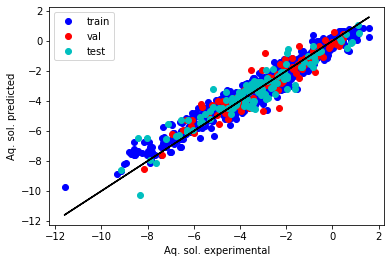

In [152]:
dire = os.path.realpath('./plots')
if not os.path.exists(dire):
    os.mkdir(dire)

x_label = 'Aq. sol. experimental'
y_label = 'Aq. sol. predicted'
parity(df_train, df_val, df_test, x_label, y_label, dire)